<a href="https://colab.research.google.com/github/YashDhruv2004/Autism-Spectrum-Disorder-prediction/blob/main/Copy_of_GCN%2BGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
cihan063_autism_image_data_path = kagglehub.dataset_download('cihan063/autism-image-data')

print('Data source import complete.')


In [ ]:
pip install torch-geometric


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.8 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from torchvision import datasets
from torch.utils.data import DataLoader
import numpy as np

In [ ]:
# GCN Model
torch.manual_seed(42)
class GCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x


class Generator(nn.Module):
    def __init__(self, z_dim, img_shape):
        super(Generator, self).__init__()
        self.fc = nn.Linear(z_dim, 128)
        self.layer = nn.Linear(128, int(np.prod(img_shape)))
        self.img_shape = img_shape

    def forward(self, z):
        out = F.relu(self.fc(z))
        img = torch.tanh(self.layer(out))
        img = img.view(img.shape[0], *self.img_shape)
        return img

# Discriminator
class Discriminator(nn.Module):
    def __init__(self, img_shape):
        super(Discriminator, self).__init__()
        self.fc = nn.Linear(int(np.prod(img_shape)), 128)
        self.out = nn.Linear(128, 1)

    def forward(self, img):
        img_flat = img.view(img.shape[0], -1)
        out = F.leaky_relu(self.fc(img_flat), 0.2)
        validity = torch.sigmoid(self.out(out))
        return validity

In [ ]:

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((64, 64)),  # Ensure all images are resized to 64x64
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
dataset = datasets.ImageFolder(root="/kaggle/input/autism-image-data", transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)


In [ ]:
n_nodes = len(dataset)
edge_index = torch.randint(0, n_nodes, (2, 100), dtype=torch.long)
print("Adjacency Matrix (Edge Index):\n", edge_index)


Adjacency Matrix (Edge Index):
 tensor([[2491, 5087, 2045, 1311, 4546, 1983, 4780, 2707, 3875,  387, 2860, 1763,
         5515,  633,  370, 2960,  103, 2917,  464, 5450,  354, 3945,  655, 1121,
         4971, 5764,  977, 4113, 5324, 5533, 1704, 5862, 5180, 4163, 3266, 2194,
         1406, 2556, 3048, 1734,  886, 1456, 2691, 5714, 2733, 2291, 5300, 2752,
         4273, 2210, 5807, 1893, 1351,  909, 4631, 2106, 2252, 2563,  324,  703,
         4232, 5664, 3613, 2163,  236, 1884, 5866,  141,  478, 2102, 1976, 1541,
         4707,   26, 3553, 3864, 2475, 2662, 3008, 5214, 2304, 2030, 3227, 3448,
         5484, 4206, 5274,    7, 4054, 5723, 4896, 5747, 4155, 3586, 3731,  165,
         4206, 3966, 3918,  665],
        [4640, 5220, 5300, 1716, 2874, 3664, 3634, 1420, 3829, 4331, 4022, 4377,
         5283, 4437,  676, 2521, 5642, 4774, 4387, 4253, 5833, 5377, 4014, 4814,
         2982, 1424, 1300,  759, 4377, 2335, 1887, 1389,  527, 3548, 3805, 4810,
         3524, 2935, 4511, 3429,  929, 5668

In [ ]:

z_dim = 100
img_shape = (1, 64, 64)  # Adjust according to dataset

gcn = GCN(64*64, 128, 64)
generator = Generator(z_dim, img_shape)
discriminator = Discriminator(img_shape)

g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)

gcn_optimizer = optim.Adam(gcn.parameters(), lr=0.001)

In [ ]:

d_losses, g_losses, accuracies, precisions, recalls, f1s, val_losses = [], [], [], [], [], [], []

def train_gan(epochs):
    global d_losses, g_losses, val_losses, accuracies, precisions, recalls, f1s
    for epoch in range(epochs):
        all_preds = []
        all_labels = []
        epoch_d_loss, epoch_g_loss = 0, 0

        for real_imgs, _ in dataloader:
            real_imgs = real_imgs.view(real_imgs.size(0), -1)
            valid = torch.ones(real_imgs.size(0), 1)
            fake = torch.zeros(real_imgs.size(0), 1)

            # Train generator
            z = torch.randn(real_imgs.size(0), z_dim)
            gen_imgs = generator(z)
            g_loss = F.binary_cross_entropy(discriminator(gen_imgs), valid)
            g_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()

            # Train discriminator
            real_loss = F.binary_cross_entropy(discriminator(real_imgs), valid)
            fake_loss = F.binary_cross_entropy(discriminator(gen_imgs.detach()), fake)
            d_loss = (real_loss + fake_loss) / 2
            d_optimizer.zero_grad()
            d_loss.backward()
            d_optimizer.step()

            epoch_d_loss += d_loss.item()
            epoch_g_loss += g_loss.item()

            # Store predictions and labels for evaluation
            preds = discriminator(real_imgs).detach().cpu().numpy().round()
            labels = valid.detach().cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels)

        # Calculate metrics
        accuracy = accuracy_score(all_labels, all_preds)
        precision = precision_score(all_labels, all_preds, zero_division=1)
        recall = recall_score(all_labels, all_preds, zero_division=1)
        f1 = f1_score(all_labels, all_preds, zero_division=1)

        # Append training losses and metrics
        d_losses.append(epoch_d_loss / len(dataloader))
        g_losses.append(epoch_g_loss / len(dataloader))
        accuracies.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
        f1s.append(f1)

        # Compute validation loss
        val_loss = 0
        with torch.no_grad():
            for real_imgs, _ in dataloader:  # Using the same dataloader (adjust if needed)
                real_imgs = real_imgs.view(real_imgs.size(0), -1)
                z = torch.randn(real_imgs.size(0), z_dim)
                gen_imgs = generator(z)
                val_loss += F.binary_cross_entropy(discriminator(gen_imgs), torch.ones(real_imgs.size(0), 1)).item()
        val_losses.append(val_loss / len(dataloader))  # Average validation loss

        print(f"Epoch {epoch+1}/{epochs} | D Loss: {d_losses[-1]:.4f} | G Loss: {g_losses[-1]:.4f} | Val Loss: {val_losses[-1]:.4f} | Acc: {accuracy:.4f} | Prec: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f}")


epochs = 20


train_gan(epochs)


Epoch 1/20 | D Loss: 0.0894 | G Loss: 3.4282 | Val Loss: 2.6269 | Acc: 0.9646 | Prec: 1.0000 | Recall: 0.9646 | F1: 0.9820
Epoch 2/20 | D Loss: 0.1073 | G Loss: 3.2100 | Val Loss: 2.2062 | Acc: 0.9531 | Prec: 1.0000 | Recall: 0.9531 | F1: 0.9760
Epoch 3/20 | D Loss: 0.1185 | G Loss: 3.1029 | Val Loss: 2.8819 | Acc: 0.9452 | Prec: 1.0000 | Recall: 0.9452 | F1: 0.9718
Epoch 4/20 | D Loss: 0.1003 | G Loss: 3.2812 | Val Loss: 4.0272 | Acc: 0.9554 | Prec: 1.0000 | Recall: 0.9554 | F1: 0.9772
Epoch 5/20 | D Loss: 0.0665 | G Loss: 3.5134 | Val Loss: 3.3470 | Acc: 0.9804 | Prec: 1.0000 | Recall: 0.9804 | F1: 0.9901
Epoch 6/20 | D Loss: 0.0499 | G Loss: 4.0841 | Val Loss: 4.1633 | Acc: 0.9879 | Prec: 1.0000 | Recall: 0.9879 | F1: 0.9939
Epoch 7/20 | D Loss: 0.0395 | G Loss: 4.0059 | Val Loss: 4.0882 | Acc: 0.9935 | Prec: 1.0000 | Recall: 0.9935 | F1: 0.9968
Epoch 8/20 | D Loss: 0.0440 | G Loss: 4.0449 | Val Loss: 3.6210 | Acc: 0.9896 | Prec: 1.0000 | Recall: 0.9896 | F1: 0.9948
Epoch 9/20 | D L

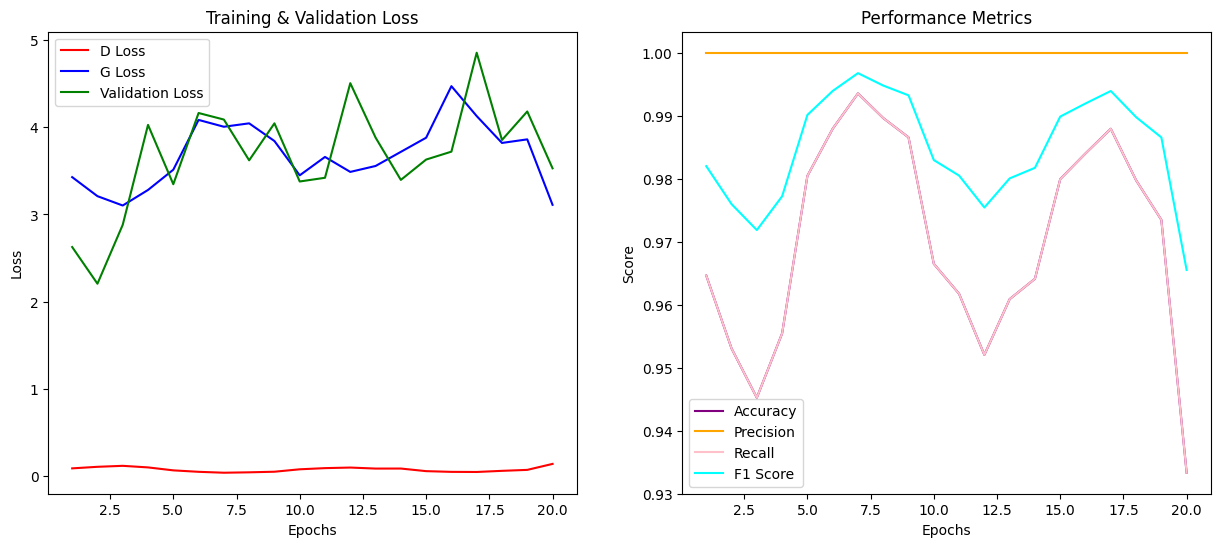

In [ ]:
import matplotlib.pyplot as plt

def plot_training_results(epochs, d_losses, g_losses, val_losses, accuracies, precisions, recalls, f1s):
    plt.figure(figsize=(15, 6))

    # Plot Training & Validation Losses
    plt.subplot(1,2,1)
    plt.plot(range(1, epochs+1), d_losses, label='D Loss', color='red')
    plt.plot(range(1, epochs+1), g_losses, label='G Loss', color='blue')
    plt.plot(range(1, epochs+1), val_losses, label='Validation Loss', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training & Validation Loss')

    # Plot Performance Metrics
    plt.subplot(1,2,2)
    plt.plot(range(1, epochs+1), accuracies, label='Accuracy', color='purple')
    plt.plot(range(1, epochs+1), precisions, label='Precision', color='orange')
    plt.plot(range(1, epochs+1), recalls, label='Recall', color='pink')
    plt.plot(range(1, epochs+1), f1s, label='F1 Score', color='cyan')
    plt.xlabel('Epochs')
    plt.ylabel('Score')
    plt.legend()
    plt.title('Performance Metrics')

    plt.show()

# Now, call the function
plot_training_results(epochs, d_losses, g_losses, val_losses, accuracies, precisions, recalls, f1s)
